# Beauty Recommender System
This notebook demonstrates how to build **object‑oriented** recommendation logic on the synthetic Ulta interactions dataset generated earlier.

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

pd.set_option('display.max_columns', None)

## 1. Load synthetic dataset

In [2]:
df = pd.read_csv("../data/synthetic_product_data.csv")
df.head()

,user_id,sku,timestamp,view_seconds,add_to_cart,purchase_spend,level1,level2,level3
0,4725,200017,2024-08-16,9,False,0.0,Makeup,Lips,Lip Balm
1,3126,200010,2024-07-11,85,True,0.0,Makeup,Face,Blush
2,3421,200000,2025-04-17,52,False,0.0,Hair,Shampoo,Volumizing
3,4487,200013,2024-10-20,68,False,0.0,Makeup,Eyes,Eyeshadow
4,2892,200004,2024-06-08,37,True,0.0,Hair,Conditioner,Repair


## 2. Build an **implicit feedback** score
Combine the interaction columns into a single numerical score:
* `view_seconds / 30`
* `+ 2` if `add_to_cart`
* `+ 5` if `purchase_spend > 0`

These weights are arbitrary but demonstrate how different signals can be blended.

In [3]:
df['score'] = (
    df['view_seconds'] / 30
    + df['add_to_cart'].astype(int) * 2
    + (df['purchase_spend'] > 0).astype(int) * 5
)
df["label"] = ((df["add_to_cart"] == 1) | (df["purchase_spend"] > 0)).astype(float)
df[['user_id', 'sku', 'score']].head()

,user_id,sku,score
0,4725,200017,0.300000
1,3126,200010,4.833333
2,3421,200000,1.733333
3,4487,200013,2.266667
4,2892,200004,3.233333


### 2.1 Interaction matrix

In [4]:
interaction_mat = df.pivot_table(index='user_id', columns='sku', values='score', aggfunc='sum', fill_value=0)
interaction_mat.head()

sku,200000,200001,200002,200003,200004,200005,200006,200007,200008,200009,200010,200011,200012,200013,200014,200015,200016,200017,200018,200019,200020,200021,200022,200023,200024,200025,200026
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.600000,0.000000,6.266667,0.0,2.433333,1.366667,3.166667,0.000000,0.000000,4.866667,0.166667,3.033333,3.033333,0.533333,1.966667,4.733333,0.000000,6.4,9.1,0.000000,2.000000,0.000000,6.566667,0.000000,0.000000,0.000000,7.900000
2,6.333333,14.866667,4.200000,0.0,0.000000,20.366667,0.900000,0.000000,7.833333,0.000000,0.000000,2.366667,0.000000,2.600000,0.000000,0.733333,0.000000,0.0,0.8,0.000000,0.266667,2.033333,0.000000,1.833333,3.533333,0.000000,0.000000
3,5.633333,0.000000,8.566667,0.0,1.933333,0.000000,0.000000,0.000000,3.466667,2.466667,11.766667,1.100000,2.400000,0.000000,2.666667,5.766667,0.000000,0.0,0.0,1.900000,4.900000,0.000000,0.000000,0.000000,0.000000,1.200000,0.000000
4,2.400000,0.000000,3.300000,0.0,4.300000,0.000000,8.700000,1.333333,0.000000,0.400000,1.533333,3.166667,0.000000,0.800000,4.500000,3.066667,0.000000,0.0,0.0,4.766667,0.000000,2.533333,0.800000,0.000000,3.866667,3.066667,3.866667
5,0.000000,3.000000,0.000000,0.0,0.533333,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,4.966667,0.000000,6.166667,0.000000,0.000000,1.533333,0.0,0.0,0.400000,0.400000,0.000000,0.000000,9.233333,3.166667,5.966667,3.433333


### 2.2 User Clustering

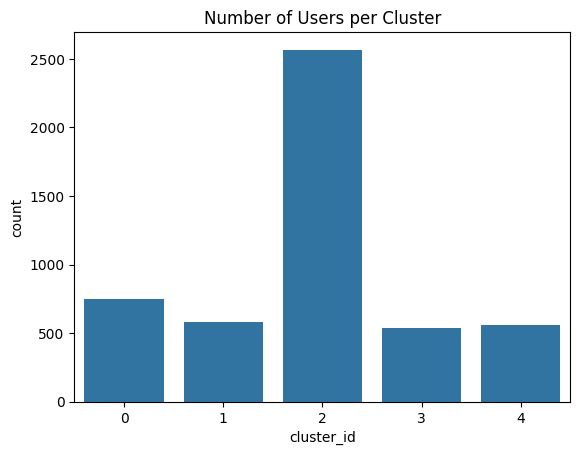

In [5]:
from sklearn.cluster import KMeans

n_clusters = 5

# Fit KMeans on user vectors
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
user_clusters = kmeans.fit_predict(interaction_mat)

# Add cluster ID to the interaction matrix
interaction_mat['cluster_id'] = user_clusters

##%%
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize user count per cluster
sns.countplot(x='cluster_id', data=interaction_mat)
plt.title('Number of Users per Cluster')
plt.show()

##  3. Two-Stage Retrieval ➜ Ranking  
Retrieve **K** likely items (`Retriever`) and then pass them to a `Ranker` for fine-grained ordering.

In [6]:
from abc import ABC, abstractmethod

class Retriever(ABC):
    @abstractmethod
    def fit(self, interaction_matrix: pd.DataFrame):
        pass

    @abstractmethod
    def retrieve(self, user_id: int, k: int = 100):
        """Return a list of K candidate SKU IDs."""
        pass


class Ranker(ABC):
    @abstractmethod
    def fit(self, *args, **kwargs):
        pass

    @abstractmethod
    def rank(self, user_id: int, candidates: list[int], k: int = 10):
        """Return the top k candidates in ranked order."""
        pass

In [7]:
class ItemSimRetriever(Retriever):
    """Cosine-similarity retriever."""
    def fit(self, interaction_matrix: pd.DataFrame):
        self.inter_matrix_ = interaction_matrix
        item_mat = normalize(interaction_matrix.T, norm='l2')
        self.sim_ = cosine_similarity(item_mat)
        self.sku_index_ = list(interaction_matrix.columns)
        self.index_sku_ = {i: sku for i, sku in enumerate(self.sku_index_)}

    def retrieve(self, user_id: int, k: int = 100):
        user_vec = self.inter_matrix_.loc[user_id].values.reshape(1, -1)
        scores = (self.sim_ @ user_vec.T).flatten()
    
        # Mask seen items
        scores[self.inter_matrix_.loc[user_id] > 0] = -np.inf
    
        
        valid_idx = np.where(scores > -np.inf)[0]
        k = min(k, len(valid_idx)) 
    
        if k == 0:
            return []  
    
        top_idx = valid_idx[np.argpartition(scores[valid_idx], -k)[-k:]]
        return [self.index_sku_[i] for i in top_idx]


In [8]:
class WeightedScoreRanker(Ranker):
    def __init__(self, pop_weight=1.0, cart_weight=2.0, pur_weight=5.0):
        self.pop_w = pop_weight
        self.cart_w = cart_weight
        self.pur_w  = pur_weight

    def fit(self, events: pd.DataFrame):
        grp = events.groupby('sku')
        self.popularity_ = grp.size()
        self.cart_rate_  = grp['add_to_cart'].mean()
        self.pur_rate_ = grp['purchase_spend'].apply(lambda x: (x > 0).mean())


    def _score(self, sku):
        return (
            self.pop_w * self.popularity_.get(sku, 0)
            + self.cart_w * self.cart_rate_.get(sku, 0)
            + self.pur_w  * self.pur_rate_.get(sku, 0)
        )

    def rank(self, user_id: int, candidates: list[int], k: int = 10):
        ranked = sorted(candidates, key=self._score, reverse=True)
        return ranked[:k]

# Dependencies
from typing import List

# Gradient-Boosted Trees
from xgboost import XGBRanker

# Two-Tower Network
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset



# Abstract Base
class Ranker(ABC):
    @abstractmethod
    def fit(self, events: pd.DataFrame):
        ...

    @abstractmethod
    def rank(self, user_id: int, candidates: List[int], k: int = 10):
        ...


class GBTRanker(Ranker):
    """
    Gradient-Boosted Trees (XGBRanker) pointwise implementation.
    Expects `events` with columns: user_id, sku, label (higher == better).
    """

    def __init__(self, **xgb_params):
        default_params = dict(
            objective="rank:pairwise",
            n_estimators=300,
            learning_rate=0.1,
            max_depth=6,
            subsample=0.9,
            colsample_bytree=0.8,
            random_state=42,
        )
        default_params.update(xgb_params)
        self.model = XGBRanker(**default_params)


    @staticmethod
    def _build_features(df: pd.DataFrame) -> pd.DataFrame:
        """Simple numeric feature set; extend as needed."""
        grp = df.groupby("sku")
        return pd.DataFrame(
            {
                "popularity": grp.size(),
                "cart_rate": grp["add_to_cart"].mean(),
                "purchase_rate": grp['purchase_spend'].apply(lambda x: (x > 0).mean()),
            }
        )


    def fit(self, events: pd.DataFrame):
        # Build features
        feats = self._build_features(events)
        evt = events.join(feats, on="sku")

        # XGBoost needs query groups === lengths per user
        groups = evt.groupby("user_id").size().values
        X = evt[["popularity", "cart_rate", "purchase_rate"]].values
        y = evt["label"].values  # e.g., clicks or spend

        self.model.fit(X, y, group=groups)

        # Cache features for inference
        self._feat_lookup = feats.to_dict("index")

    def _vectorize(self, sku):
        f = self._feat_lookup.get(sku, {"popularity": 0, "cart_rate": 0, "purchase_rate": 0})
        return np.array([[f["popularity"], f["cart_rate"], f["purchase_rate"]]])

    def rank(self, user_id: int, candidates: List[int], k: int = 10):
        X_pred = np.vstack([self._vectorize(s) for s in candidates])
        scores = self.model.predict(X_pred)
        ranked = [c for c, _ in sorted(zip(candidates, scores), key=lambda t: t[1], reverse=True)]
        return ranked[:k]


In [9]:
gbr = GBTRanker(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    random_state=42,
)
gbr.fit(df)                         

user_id     = 12345                     
candidates  = [200001, 200003, 200021]  # list[int] of SKU IDs
top_10      = gbr.rank(user_id, candidates, k=10)
print("GBTRanker recommendations:", top_10)


GBTRanker recommendations: [200021, 200001, 200003]
